In [58]:
import os
import re
import unicodedata
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import textstat
from textblob import TextBlob
from textblob_nl import PatternAnalyzer
from tqdm.notebook import tqdm
import requests
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.cm as cm
import matplotlib.colors as mcolors


split data:

### Splitsen van Tijdreeksdataset in Trainings- en Testset met Export naar CSV

Deze code laadt een samengestelde dataset met verkoop- en trendgegevens in en voert een tijdreeksbewuste 80/20-splitsing uit, waarbij de eerste 80% van de rijen als trainingsdata worden gemarkeerd en de laatste 20% als testdata. Elke subset krijgt een bijbehorende aanduiding (‘Train’ of ‘Test’) en wordt afzonderlijk opgeslagen als CSV-bestand voor verdere analyse of modeltraining.



In [2]:


# Load the dataset
joined_df = pd.read_csv(r"E:\Nieuw dataset\Joined trends\joined_trend_sales.csv")

# Perform 80/20 split
split_index = int(0.8 * len(joined_df))
train_df = joined_df.iloc[:split_index].copy()
test_df = joined_df.iloc[split_index:].copy()

# Add a column to indicate train/test set
train_df['Set'] = 'Train'
test_df['Set'] = 'Test'

# Define separate output paths for train and test sets
train_output_path = r"E:\Nieuw dataset\Joined trends\train_trend.csv"
test_output_path = r"E:\Nieuw dataset\Joined trends\test_trend.csv"

# Save each DataFrame to its own CSV
train_df.to_csv(train_output_path, index=False)
test_df.to_csv(test_output_path, index=False)


### Verkennende Data-analyse van Correlaties en Variabeleclusters in de Trainingset

Deze sectie visualiseert de onderlinge verbanden tussen numerieke variabelen in de trainingset via een correlatiematrix-heatmap en een pairplot 

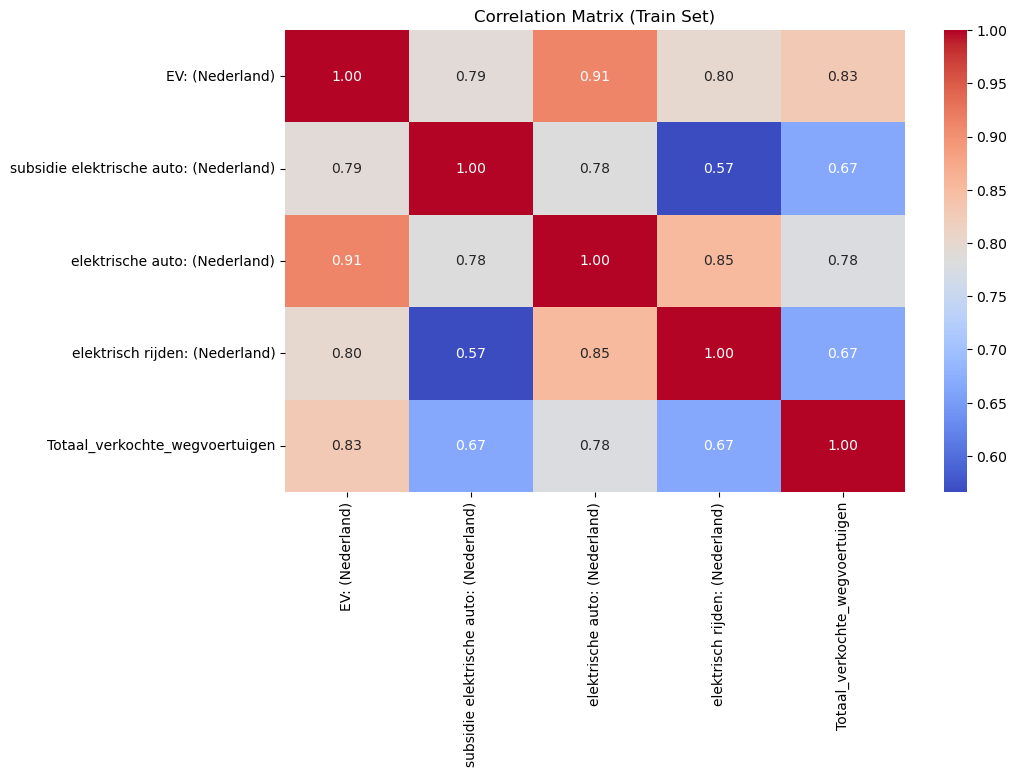

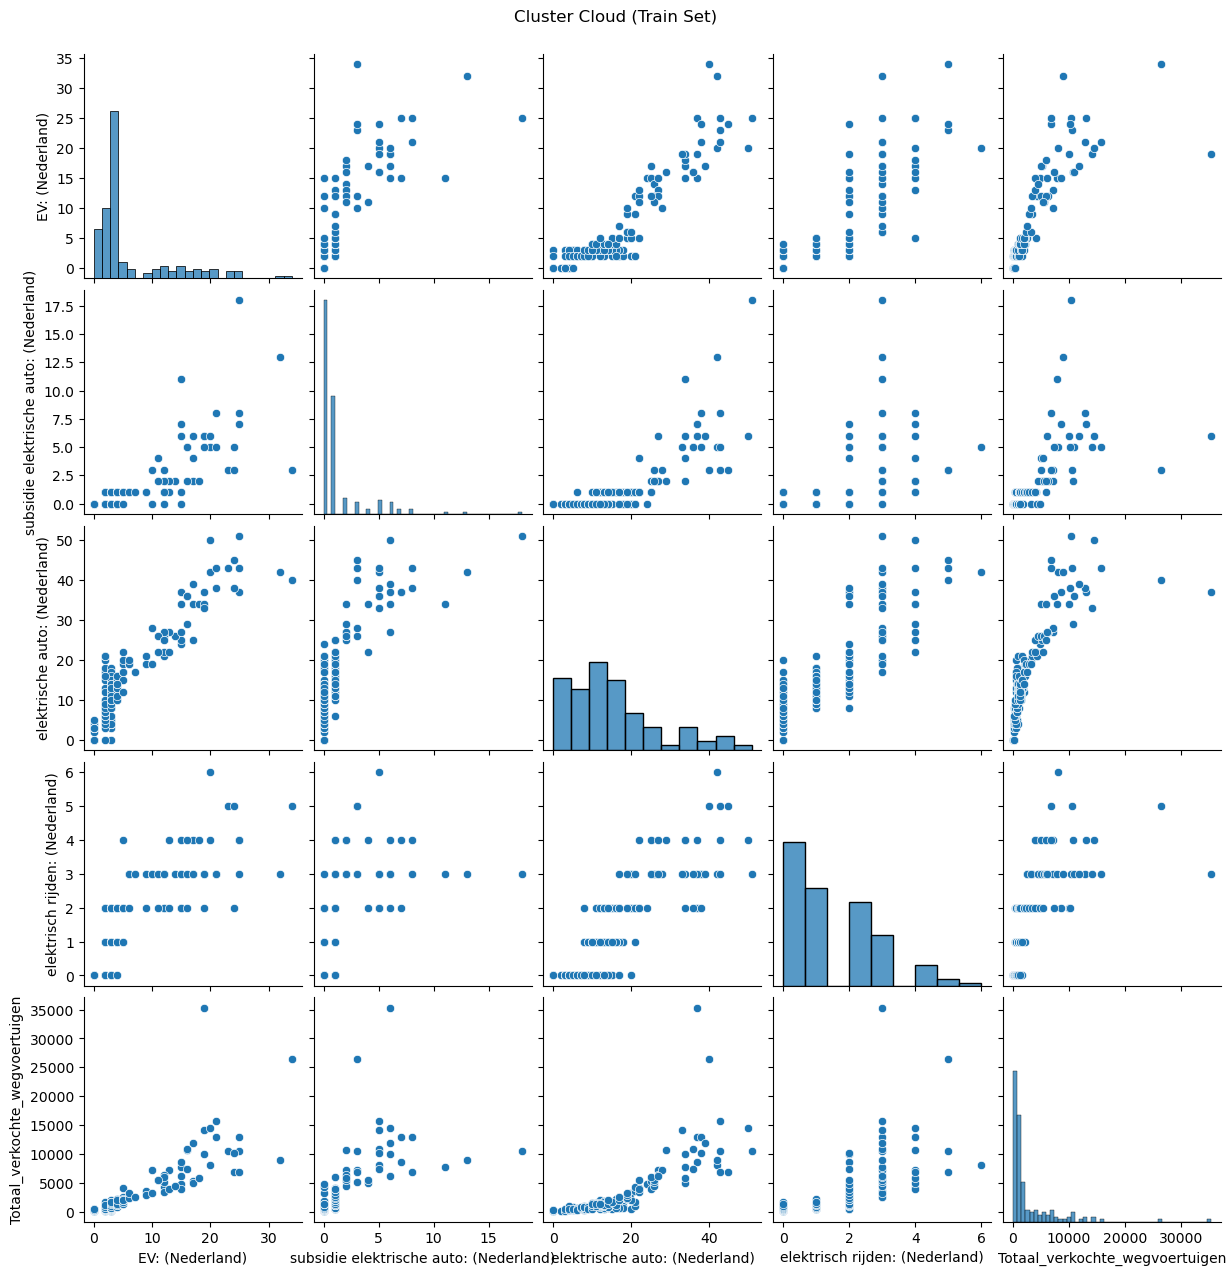

In [3]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 6))
corr = train_df.drop(columns=['Periode', 'Set']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Train Set)')
plt.show()

# Cluster cloud (pairplot)
sns.pairplot(train_df.drop(columns=['Periode', 'Set']))
plt.suptitle('Cluster Cloud (Train Set)', y=1.02)
plt.show()

### Walk-Forward XGBoost Voorspelling met MAE-analyse en Detectie van Verkooppieken

Deze script implementeert een walk-forward validatie voor tijdreeksvoorspellingen van maandelijkse voertuigverkopen met behulp van een XGBoost-regressiemodel. Elke maand wordt afzonderlijk voorspeld op basis van cumulatieve trainingsdata, waarna de voorspelling wordt vergeleken met de werkelijke waarde. De nauwkeurigheid wordt gemeten via MAE (Mean Absolute Error). Daarnaast identificeert de code automatisch de top 5% hoogste verkooppieken, die visueel worden gemarkeerd in de resultatenplot. Ook wordt de foutmarge per maand in percentages berekend en gevisualiseerd.



In [67]:
def split_features_and_target(df, target_col='Totaal_verkochte_wegvoertuigen', exclude_cols=['Periode', 'Set']):
    """
    Splitst een DataFrame in train- en validatiesets en retourneert numpy arrays:
    trainX, trainy, valX, valy, df_train, df_val, feature_cols
    """
    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]]

    split_idx = int(len(df) * 0.8)
    df_train = df.iloc[:split_idx].copy()
    df_val = df.iloc[split_idx:].copy()

    trainX = df_train[feature_cols].values
    trainy = df_train[target_col].values
    valX = df_val[feature_cols].values
    valy = df_val[target_col].values

    return trainX, trainy, valX, valy, df_train, df_val, feature_cols


Maand 2018-09-01 00:00:00: Voorspeld=4314.87, Werkelijk=4841.00, MAE=526.13
Maand 2018-10-01 00:00:00: Voorspeld=4451.04, Werkelijk=3919.00, MAE=532.04
Maand 2018-11-01 00:00:00: Voorspeld=3919.07, Werkelijk=5271.00, MAE=1351.93
Maand 2018-12-01 00:00:00: Voorspeld=4471.65, Werkelijk=7999.00, MAE=3527.35
Maand 2019-01-01 00:00:00: Voorspeld=4741.99, Werkelijk=5037.00, MAE=295.01
Maand 2019-02-01 00:00:00: Voorspeld=3727.64, Werkelijk=4418.00, MAE=690.36
Maand 2019-03-01 00:00:00: Voorspeld=3917.34, Werkelijk=7219.00, MAE=3301.66
Maand 2019-04-01 00:00:00: Voorspeld=4798.81, Werkelijk=5074.00, MAE=275.19
Maand 2019-05-01 00:00:00: Voorspeld=7054.06, Werkelijk=6291.00, MAE=763.06
Maand 2019-06-01 00:00:00: Voorspeld=6312.74, Werkelijk=7221.00, MAE=908.26
Maand 2019-07-01 00:00:00: Voorspeld=4791.43, Werkelijk=5544.00, MAE=752.57
Maand 2019-08-01 00:00:00: Voorspeld=3919.25, Werkelijk=5986.00, MAE=2066.75
Maand 2019-09-01 00:00:00: Voorspeld=5959.90, Werkelijk=10695.00, MAE=4735.10
Maand 

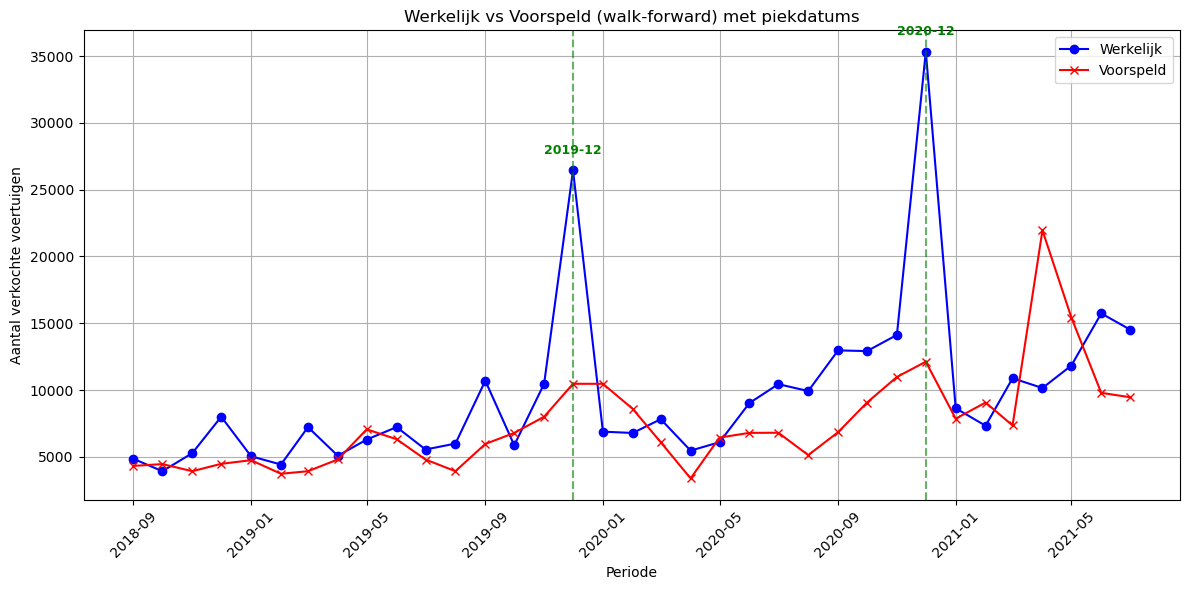

,Periode,Werkelijk,Voorspeld,Foutmarge (%)
0,2018-09-01,4841,4314.866211,-10.868287
1,2018-10-01,3919,4451.044922,13.576038
2,2018-11-01,5271,3919.067139,-25.648508
3,2018-12-01,7999,4471.648926,-44.097401
4,2019-01-01,5037,4741.985840,-5.856942
5,2019-02-01,4418,3727.636230,-15.626160
6,2019-03-01,7219,3917.336914,-45.735740
7,2019-04-01,5074,4798.805176,-5.423627
8,2019-05-01,6291,7054.061035,12.129408
9,2019-06-01,7221,6312.736816,-12.578080


     Periode  Werkelijk    Voorspeld  Foutmarge (%)
0 2018-09-01       4841  4314.866211     -10.868287
1 2018-10-01       3919  4451.044922      13.576038
2 2018-11-01       5271  3919.067139     -25.648508
3 2018-12-01       7999  4471.648926     -44.097401
4 2019-01-01       5037  4741.985840      -5.856942


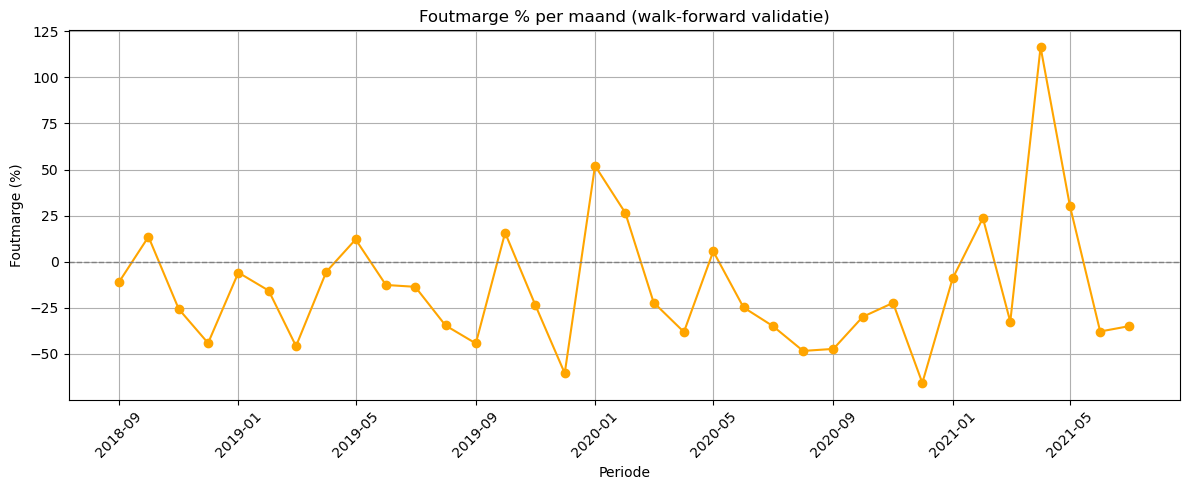

Gemiddelde absolute foutmarge (%): 31.03


In [81]:
# Define walk-forward cross-validation function
def xgboost_forecast(trainX, trainy, valx):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)  # Create XGBoost regressor model
    model.fit(trainX, trainy)  # Fit model on training data
    return model.predict(np.array([valx]))[0]  # Predict for a single validation sample

def walk_forward_prediction(df_train_full, target_col='Totaal_verkochte_wegvoertuigen'):
    trainX, trainy, valX, valy, df_train, df_val, feature_cols = split_features_and_target(df_train_full, target_col)  # Split features and target

    predictions = []  # Store predictions
    monthly_mae = []  # Store MAE per month

    for i in range(len(valX)):  # Loop over each validation sample
        valx = valX[i]  # Get validation features for this step
        yhat = xgboost_forecast(trainX, trainy, valx)  # Predict using current train set
        predictions.append(yhat)  # Save prediction

        month_mae = mean_absolute_error([valy[i]], [yhat])  # Calculate MAE for this prediction
        monthly_mae.append(month_mae)  # Save MAE
        print(f"Maand {df_val['Periode'].iloc[i]}: Voorspeld={yhat:.2f}, Werkelijk={valy[i]:.2f}, MAE={month_mae:.2f}")  # Print results

        new_row = df_val.iloc[i:i+1].copy()  # Get current validation row
        df_train = pd.concat([df_train, new_row], ignore_index=True)  # Add it to training set
        trainX = df_train[feature_cols].values  # Update training features
        trainy = df_train[target_col].values  # Update training target

    overall_mae = mean_absolute_error(valy, predictions)  # Calculate overall MAE
    print(f"\nOverall MAE op validatieset: {overall_mae:.2f}")  # Print overall MAE

    # Detecteer top 5% pieken in werkelijke verkopen
    y_actual = pd.Series(valy, index=df_val['Periode'])  # Create Series of actual values with period as index
    peak_threshold = y_actual.quantile(0.95)  # Calculate 95th percentile threshold
    peak_dates = y_actual[y_actual > peak_threshold].index  # Get dates above threshold

    print("Piekdatums (top 5% werkelijke verkopen):")  # Print header
    for date in peak_dates:  # Loop over peak dates
        print(f"- {date.strftime('%Y-%m')}")  # Print each peak date

    # Plot resultaten met pieken gemarkeerd
    plt.figure(figsize=(12, 6))  # Set plot size
    plt.plot(df_val['Periode'], valy, label='Werkelijk', marker='o', color='blue')  # Plot actual values
    plt.plot(df_val['Periode'], predictions, label='Voorspeld', marker='x', color='red')  # Plot predictions

    for pdx in peak_dates:  # Loop over peak dates
        plt.axvline(x=pdx, color='green', linestyle='--', alpha=0.6)  # Draw vertical line at peak
        plt.text(pdx, y_actual[pdx] + 1000, pdx.strftime('%Y-%m'),
                  color='green', fontsize=9, ha='center', va='bottom', fontweight='bold')  # Annotate peak

    plt.title('Werkelijk vs Voorspeld (walk-forward) met piekdatums')  # Set plot title
    plt.xlabel('Periode')  # Set x-axis label
    plt.ylabel('Aantal verkochte voertuigen')  # Set y-axis label
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.grid(True)  # Show grid
    plt.legend()  # Show legend
    plt.tight_layout()  # Adjust layout
    plt.show()  # Show plot

    return predictions, overall_mae, peak_dates  # Return results

# Run the walk-forward cross-validation
walk_forward_prediction(train_df)  # Call function on training DataFrame

# Calculate foutmarge % (percentage error) for each prediction in the validation set
foutmarge_pct = 100 * (np.array(predictions) - valy) / valy  # Compute percentage error

# Add to DataFrame for inspection
results_df = pd.DataFrame({
    'Periode': df_val['Periode'].values,  # Periods
    'Werkelijk': valy,  # Actual values
    'Voorspeld': predictions,  # Predicted values
    'Foutmarge (%)': foutmarge_pct  # Percentage error
})

display(results_df)
print(results_df[['Periode', 'Werkelijk', 'Voorspeld', 'Foutmarge (%)']].head())  # Show first rows

# Plot foutmarge % over time
plt.figure(figsize=(12, 5))  # Set plot size
plt.plot(df_val['Periode'], foutmarge_pct, marker='o', color='orange')  # Plot percentage error
plt.axhline(0, color='grey', linestyle='--', linewidth=1)  # Draw horizontal line at 0
plt.title('Foutmarge % per maand (walk-forward validatie)')  # Set plot title
plt.xlabel('Periode')  # Set x-axis label
plt.ylabel('Foutmarge (%)')  # Set y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

# Bereken en print de gemiddelde foutmarge %
gem_foutmarge_pct = np.mean(np.abs(foutmarge_pct))
print(f"Gemiddelde absolute foutmarge (%): {gem_foutmarge_pct:.2f}")


###  Walk-Forward XGBoost Voorspelling met MAE-analyse en maskeren van Verkooppieken

In [92]:
def walk_forward_prediction_filtered_verbose(df_train_full, target_col='Totaal_verkochte_wegvoertuigen', filter_peaks=True):
    trainX, trainy, valX, valy, df_train, df_val, feature_cols = split_features_and_target(df_train_full, target_col)

    predictions = []
    mae_per_maand = []

    for i in range(len(valX)):
        valx = valX[i]
        yhat = xgboost_forecast(trainX, trainy, valx)
        predictions.append(yhat)

        month_mae = mean_absolute_error([valy[i]], [yhat])
        mae_per_maand.append(month_mae)
        maand = df_val['Periode'].iloc[i].strftime('%Y-%m')
        print(f"MAE voor {maand}: {month_mae:.2f}")

        new_row = df_val.iloc[i:i+1].copy()
        df_train = pd.concat([df_train, new_row], ignore_index=True)
        trainX = df_train[feature_cols].values
        trainy = df_train[target_col].values

    y_actual_series = pd.Series(valy, index=df_val['Periode'])
    peak_threshold = y_actual_series.quantile(0.80)
    peak_dates = y_actual_series[y_actual_series > peak_threshold].index

    overall_mae_with_peaks = mean_absolute_error(valy, predictions)

    if filter_peaks:
        non_peak_mask = ~df_val['Periode'].isin(peak_dates)
        filtered_valy = valy[non_peak_mask]
        filtered_preds = np.array(predictions)[non_peak_mask]
        overall_mae_filtered = mean_absolute_error(filtered_valy, filtered_preds)
    else:
        overall_mae_filtered = overall_mae_with_peaks

    print(f"\nOverall MAE met pieken: {overall_mae_with_peaks:.2f}")
    print(f"Overall MAE zonder pieken (80e percentiel drempel {peak_threshold:.0f}): {overall_mae_filtered:.2f}\n")

    print("Piekdatums (top 20% werkelijke verkopen):")
    for date in peak_dates:
        print(f"- {date.strftime('%Y-%m')}")

    # Plot voorspellingen
    plt.figure(figsize=(14, 6))
    if filter_peaks:
        non_peak_mask = ~df_val['Periode'].isin(peak_dates)
        plt.plot(df_val['Periode'][non_peak_mask], valy[non_peak_mask], label='Werkelijk (zonder pieken)', marker='o', color='blue')
        plt.plot(df_val['Periode'][non_peak_mask], np.array(predictions)[non_peak_mask], label='Voorspeld (zonder pieken)', marker='x', color='red')
        title = 'Werkelijk vs Voorspeld (zonder pieken in grafiek)'
    else:
        plt.plot(df_val['Periode'], valy, label='Werkelijk', marker='o', color='blue')
        plt.plot(df_val['Periode'], predictions, label='Voorspeld', marker='x', color='red')
        for pdx in peak_dates:
            plt.axvline(x=pdx, color='green', linestyle='--', alpha=0.5)
            plt.text(pdx, y_actual_series[pdx] + 1000, pdx.strftime('%Y-%m'),
                     rotation=90, color='green', fontsize=9, ha='center', va='bottom', fontweight='bold')
        title = 'Werkelijk vs Voorspeld (inclusief pieken)'

    plt.title(title)
    plt.xlabel('Periode')
    plt.ylabel('Aantal verkochte voertuigen')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Foutmarge % en trendlijn
    foutmarge_pct = 100 * (np.array(predictions) - valy) / valy
    plt.figure(figsize=(12, 5))
    plt.plot(df_val['Periode'], foutmarge_pct, marker='o', color='orange', label='Foutmarge (%)', linestyle='--')
    x = np.arange(len(foutmarge_pct))
    z = np.polyfit(x, foutmarge_pct, 1)
    p = np.poly1d(z)
    plt.plot(df_val['Periode'], p(x), color='blue', linestyle='--', label='Trend')
    plt.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.title('Foutmarge % per maand (walk-forward validatie)')
    plt.xlabel('Periode')
    plt.ylabel('Foutmarge (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Resultaten opslaan
    results_df = pd.DataFrame({
        'Periode': df_val['Periode'].values,
        'Werkelijk': valy,
        'Voorspeld': predictions,
        'Foutmarge (%)': foutmarge_pct,
        'MAE per maand': mae_per_maand
    })

    # Bereken gemiddelde foutmarge (zonder pieken indien gewenst)
    if filter_peaks:
        non_peak_mask = ~df_val['Periode'].isin(peak_dates)
        foutmarge_filtered = results_df['Foutmarge (%)'][non_peak_mask.values]

        gem_foutmarge_pct = np.mean(np.abs(foutmarge_filtered))
    else:
        gem_foutmarge_pct = np.mean(np.abs(results_df['Foutmarge (%)']))

    print(f"Gemiddelde absolute foutmarge (%): {gem_foutmarge_pct:.2f}")

    return predictions, overall_mae_filtered, overall_mae_with_peaks, peak_dates, results_df


MAE voor 2018-09: 526.13
MAE voor 2018-10: 532.04
MAE voor 2018-11: 1351.93
MAE voor 2018-12: 3527.35
MAE voor 2019-01: 295.01
MAE voor 2019-02: 690.36
MAE voor 2019-03: 3301.66
MAE voor 2019-04: 275.19
MAE voor 2019-05: 763.06
MAE voor 2019-06: 908.26
MAE voor 2019-07: 752.57
MAE voor 2019-08: 2066.75
MAE voor 2019-09: 4735.10
MAE voor 2019-10: 922.50
MAE voor 2019-11: 2467.81
MAE voor 2019-12: 15994.46
MAE voor 2020-01: 3584.61
MAE voor 2020-02: 1799.54
MAE voor 2020-03: 1725.21
MAE voor 2020-04: 2078.41
MAE voor 2020-05: 345.54
MAE voor 2020-06: 2234.03
MAE voor 2020-07: 3638.82
MAE voor 2020-08: 4797.33
MAE voor 2020-09: 6126.39
MAE voor 2020-10: 3854.40
MAE voor 2020-11: 3148.78
MAE voor 2020-12: 23220.37
MAE voor 2021-01: 781.24
MAE voor 2021-02: 1736.96
MAE voor 2021-03: 3536.37
MAE voor 2021-04: 11814.60
MAE voor 2021-05: 3596.13
MAE voor 2021-06: 5949.72
MAE voor 2021-07: 5063.61

Overall MAE met pieken: 3661.21
Overall MAE zonder pieken (80e percentiel drempel 12050): 2313.73

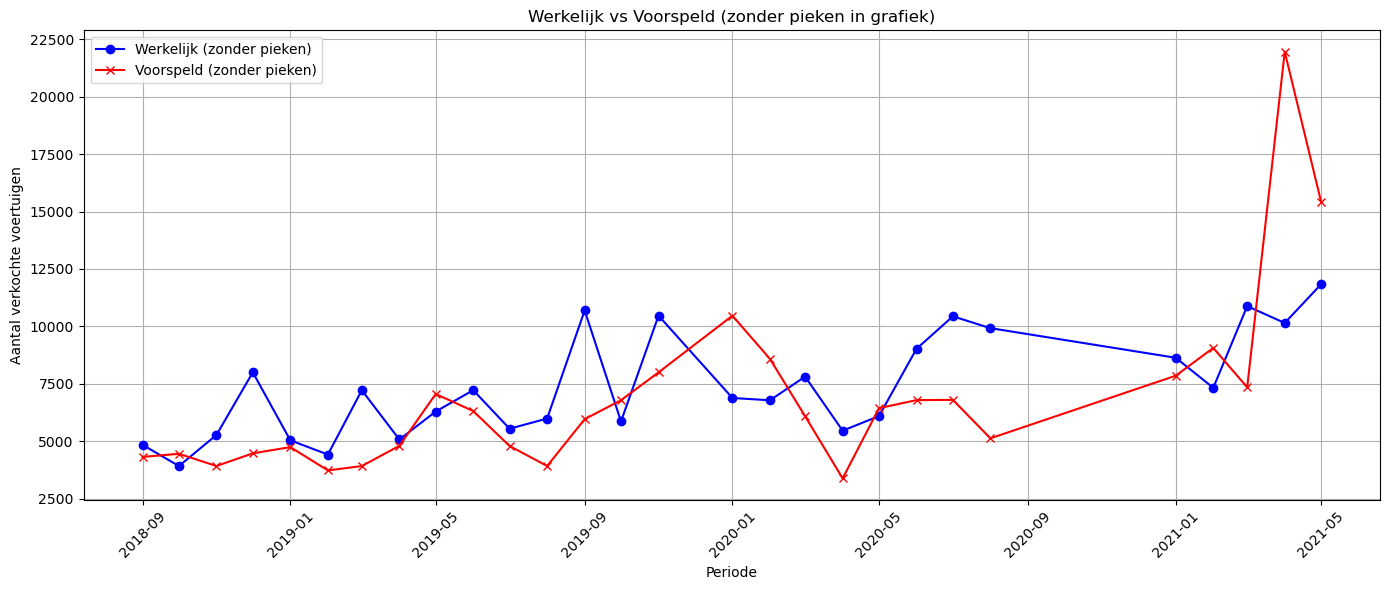

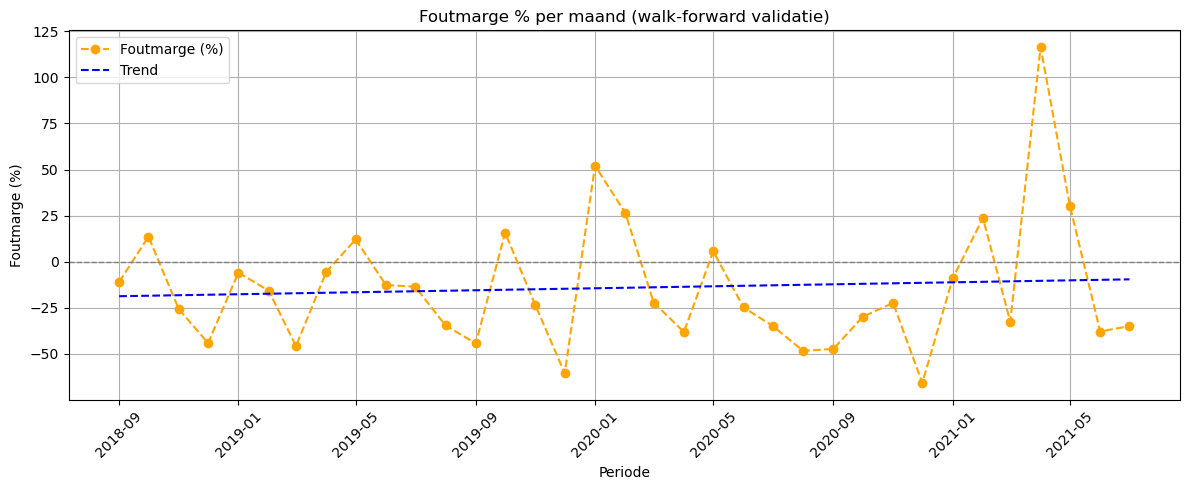

Gemiddelde absolute foutmarge (%): 28.13


In [93]:
predictions, mae_filtered, mae_all, peak_dates, results_df = walk_forward_prediction_filtered_verbose(train_df, filter_peaks=True)


Berekenen tot feb 2021 om de grote voorspellende voor te zijn, ik verwacht dat de MAE/foutmarge groot is vanwege die piek op het eind.

In [96]:
def walk_forward_prediction_filtered_verbose(df_train_full, target_col='Totaal_verkochte_wegvoertuigen', filter_peaks=True):
    # Split de data
    trainX, trainy, valX, valy, df_train, df_val, feature_cols = split_features_and_target(df_train_full, target_col)

    # Filter validatieperiode tot en met februari 2021
    df_val = df_val[df_val['Periode'] <= '2021-02']
    valX = df_val[feature_cols].values
    valy = df_val[target_col].values

    predictions = []
    mae_per_maand = []

    for i in range(len(valX)):
        valx = valX[i]
        yhat = xgboost_forecast(trainX, trainy, valx)
        predictions.append(yhat)

        month_mae = mean_absolute_error([valy[i]], [yhat])
        mae_per_maand.append(month_mae)
        maand = df_val['Periode'].iloc[i].strftime('%Y-%m')
        print(f"MAE voor {maand}: {month_mae:.2f}")

        new_row = df_val.iloc[i:i+1].copy()
        df_train = pd.concat([df_train, new_row], ignore_index=True)
        trainX = df_train[feature_cols].values
        trainy = df_train[target_col].values

    y_actual_series = pd.Series(valy, index=df_val['Periode'])
    peak_threshold = y_actual_series.quantile(0.80)
    peak_dates = y_actual_series[y_actual_series > peak_threshold].index

    overall_mae_with_peaks = mean_absolute_error(valy, predictions)

    if filter_peaks:
        non_peak_mask = ~df_val['Periode'].isin(peak_dates)
        filtered_valy = valy[non_peak_mask]
        filtered_preds = np.array(predictions)[non_peak_mask]
        overall_mae_filtered = mean_absolute_error(filtered_valy, filtered_preds)
    else:
        overall_mae_filtered = overall_mae_with_peaks

    print(f"\nOverall MAE met pieken: {overall_mae_with_peaks:.2f}")
    print(f"Overall MAE zonder pieken (80e percentiel drempel {peak_threshold:.0f}): {overall_mae_filtered:.2f}\n")

    print("Piekdatums (top 20% werkelijke verkopen):")
    for date in peak_dates:
        print(f"- {date.strftime('%Y-%m')}")

    # Plot voorspellingen
    plt.figure(figsize=(14, 6))
    if filter_peaks:
        non_peak_mask = ~df_val['Periode'].isin(peak_dates)
        plt.plot(df_val['Periode'][non_peak_mask], valy[non_peak_mask], label='Werkelijk (zonder pieken)', marker='o', color='blue')
        plt.plot(df_val['Periode'][non_peak_mask], np.array(predictions)[non_peak_mask], label='Voorspeld (zonder pieken)', marker='x', color='red')
        title = 'Werkelijk vs Voorspeld (zonder pieken in grafiek)'
    else:
        plt.plot(df_val['Periode'], valy, label='Werkelijk', marker='o', color='blue')
        plt.plot(df_val['Periode'], predictions, label='Voorspeld', marker='x', color='red')
        for pdx in peak_dates:
            plt.axvline(x=pdx, color='green', linestyle='--', alpha=0.5)
            plt.text(pdx, y_actual_series[pdx] + 1000, pdx.strftime('%Y-%m'),
                     rotation=90, color='green', fontsize=9, ha='center', va='bottom', fontweight='bold')
        title = 'Werkelijk vs Voorspeld (inclusief pieken)'

    plt.title(title)
    plt.xlabel('Periode')
    plt.ylabel('Aantal verkochte voertuigen')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Foutmarge % en trendlijn
    foutmarge_pct = 100 * (np.array(predictions) - valy) / valy

    # Cumulatieve foutmarge (vanaf het begin optellen)
    cumulatieve_foutmarge = np.cumsum(foutmarge_pct)

    plt.figure(figsize=(12, 5))
    plt.plot(df_val['Periode'], foutmarge_pct, marker='o', color='orange', label='Foutmarge (%)', linestyle='--')
    plt.plot(df_val['Periode'], cumulatieve_foutmarge, marker='s', color='purple', label='Cumulatieve foutmarge (%)', linestyle='-')
    x = np.arange(len(foutmarge_pct))
    z = np.polyfit(x, foutmarge_pct, 1)
    p = np.poly1d(z)
    plt.plot(df_val['Periode'], p(x), color='blue', linestyle='--', label='Trend')
    plt.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.title('Foutmarge % per maand en cumulatief (walk-forward validatie)')
    plt.xlabel('Periode')
    plt.ylabel('Foutmarge (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Resultaten opslaan
    results_df = pd.DataFrame({
        'Periode': df_val['Periode'].values,
        'Werkelijk': valy,
        'Voorspeld': predictions,
        'Foutmarge (%)': foutmarge_pct,
        'MAE per maand': mae_per_maand
    })

    if filter_peaks:
        non_peak_mask = ~df_val['Periode'].isin(peak_dates)
        foutmarge_filtered = results_df['Foutmarge (%)'][non_peak_mask.values]
        gem_foutmarge_pct = np.mean(np.abs(foutmarge_filtered))
    else:
        gem_foutmarge_pct = np.mean(np.abs(results_df['Foutmarge (%)']))

    print(f"Gemiddelde absolute foutmarge (%): {gem_foutmarge_pct:.2f}")

    return predictions, overall_mae_filtered, overall_mae_with_peaks, peak_dates, results_df


MAE voor 2018-09: 526.13
MAE voor 2018-10: 532.04
MAE voor 2018-11: 1351.93
MAE voor 2018-12: 3527.35
MAE voor 2019-01: 295.01
MAE voor 2019-02: 690.36
MAE voor 2019-03: 3301.66
MAE voor 2019-04: 275.19
MAE voor 2019-05: 763.06
MAE voor 2019-06: 908.26
MAE voor 2019-07: 752.57
MAE voor 2019-08: 2066.75
MAE voor 2019-09: 4735.10
MAE voor 2019-10: 922.50
MAE voor 2019-11: 2467.81
MAE voor 2019-12: 15994.46
MAE voor 2020-01: 3584.61
MAE voor 2020-02: 1799.54
MAE voor 2020-03: 1725.21
MAE voor 2020-04: 2078.41
MAE voor 2020-05: 345.54
MAE voor 2020-06: 2234.03
MAE voor 2020-07: 3638.82
MAE voor 2020-08: 4797.33
MAE voor 2020-09: 6126.39
MAE voor 2020-10: 3854.40
MAE voor 2020-11: 3148.78
MAE voor 2020-12: 23220.37
MAE voor 2021-01: 781.24
MAE voor 2021-02: 1736.96

Overall MAE met pieken: 3272.73
Overall MAE zonder pieken (80e percentiel drempel 10512): 1712.60

Piekdatums (top 20% werkelijke verkopen):
- 2019-09
- 2019-12
- 2020-09
- 2020-10
- 2020-11
- 2020-12


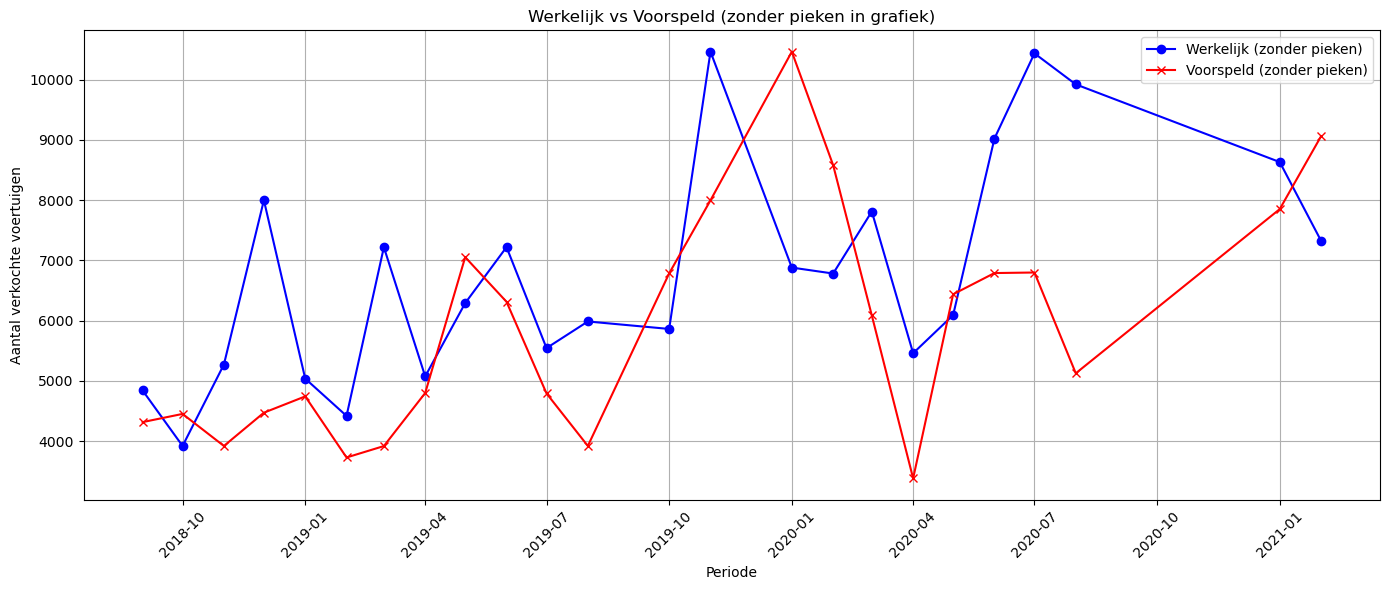

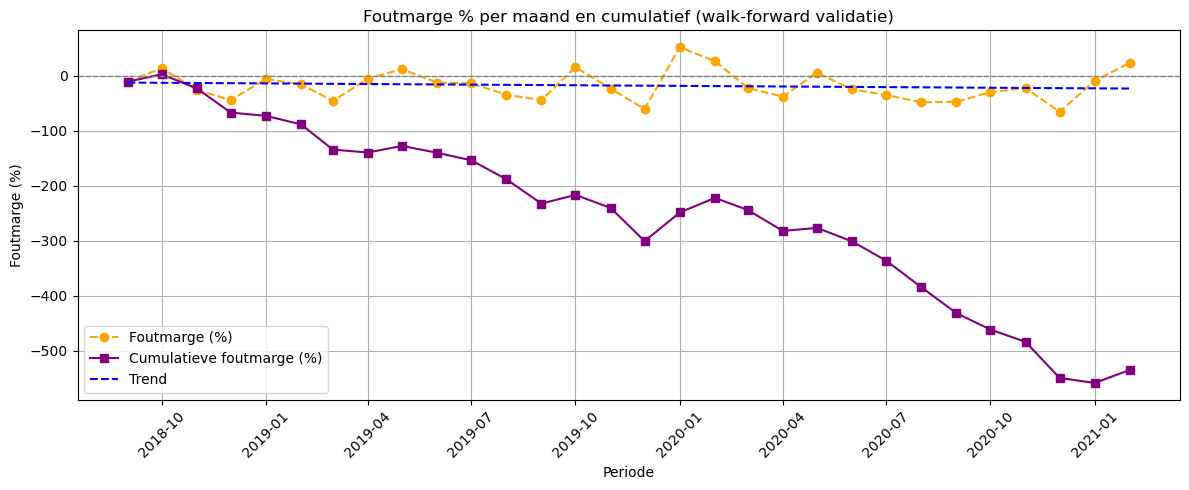

Gemiddelde absolute foutmarge (%): 23.51


In [97]:
predictions, mae_filtered, mae_all, peak_dates, results_df = walk_forward_prediction_filtered_verbose(train_df, filter_peaks=True)

